# Installing library

By Junwoo Yun

In [ ]:
!pip install optuna
!pip install eli5

     |████████████████████████████████| 296kB 9.9MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 163kB 17.1MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 143kB 38.2MB/s 
     |████████████████████████████████| 112kB 43.4MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=2468225b4244ee40721840da73dfa1cd37f84213118324d09d67e1a0d1fc0e5b
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


# Library + Data Loading

In [ ]:
import pandas as pd
import numpy as np
import optuna
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Linear - 2 classification, 2 regression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Lasso, RidgeClassifier
from sklearn.linear_model import HuberRegressor, OrthogonalMatchingPursuit, BayesianRidge

#SVM - Regression, Classification
from sklearn.svm import SVR, SVC

#Tree - 3 Tree and each 2 has Regression and Classification model
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor

#Boosting Tree model - 2
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GroupKFold, KFold, cross_val_score, TimeSeriesSplit

In [ ]:
# Loading Train and Test data 
PATH = '/content/drive/MyDrive/dacon/datathon/'
df_train = pd.read_csv(PATH+'train.csv')

y_classification = df_train['match_result']
y_regression = df_train['match_result_rel']
groups = df_train['season']
df_train = pd.get_dummies(df_train, columns=['league_id'])
train = df_train.drop(columns = ['match_result','match_result_rel','season'])

df_test = pd.read_csv(PATH+'test.csv')
df_past = pd.read_csv(PATH+'train.csv')
df_test = pd.concat([df_past[-2000:],df_test], ignore_index=True)
y_classification_test = df_test['match_result']
y_regression_test = df_test['match_result_rel']
groups_test = df_test['season']
df_test = pd.get_dummies(df_test, columns=['league_id'])
test = df_test.drop(columns = ['match_result','match_result_rel','season'])

# List of Models

In [ ]:
from sklearn.utils.extmath import softmax

#customized ridge classifier due to no predict_proba
class RidgeClassifierwithProba(RidgeClassifier):
    def predict_proba(self, X):
      d = self.decision_function(X)
      probs = np.exp(d) / (1 + np.exp(d))
      return probs

params = {"random_state": 42} #later for tunining

classification_models = [
    ['LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()],
    ['RidgeClassifier', RidgeClassifierwithProba(**params)],
    ['DecisionTreeClassifier', DecisionTreeClassifier(**params)],
    ['ExtraTreesClassifier', ExtraTreesClassifier(**params)],
    ['RandomForestClassifier', RandomForestClassifier(**params)],
    ['XGBClassifier', XGBClassifier(**params)],
    ['LGBMClassifier', LGBMClassifier(**params)]
#   ['svc_linear', SVC(**params, kernel = 'linear')),
#   ['svc_rbf', SVC(**params, kernel = 'rbf'))
]
regression_models = [
    ['LinearRegression', LinearRegression()],
    ['Lasso', Lasso(**params)],
    ['DecisionTreeRegressor', DecisionTreeRegressor(**params)],
    ['ExtraTreesRegressor', ExtraTreesRegressor(**params)],
    ['RandomForestRegressor', RandomForestRegressor(**params)],
    ['XGBRegressor', XGBRegressor(objective = "reg:squarederror", **params)],
    ['LGBMRegressor', LGBMRegressor(**params)],
    ['OrthogonalMatchingPursuit', OrthogonalMatchingPursuit()],
    ['HuberRegressor', HuberRegressor()],
    ['BayesianRidge', BayesianRidge()]
#   ['svc_linear', SVC(**params, kernel = 'linear')),
#   ['svr_rbf', SVC(**params, kernel = 'rbf'))              
]

# Rolling Functions

In [ ]:
def roll_win_pred(X, y, model, train_win=200, valid_win=20, c=False):
  """
  X: pure features with match_id and date, pd.DataFrame
  y: target variable - pd.Series
  model: sklearn model
  train_win: training window
  valid_win: valid window right next to training window
  c: if classificatoin True, if regression False
  return: validation/testing data series with columns ['match_id', 'date', 'pred'] or ['match_id', 'date', '0','1','2']
  """
  
  dates = X['date']
  match_ids = X['match_id']
  X = X.drop(columns = ['date', 'match_id'])

  if not c:
    res_valid = pd.DataFrame(columns=['match_id', 'date','pred'])
  else:
    res_valid = pd.DataFrame(columns=['match_id', 'date','0','1','2'])

  for i in range(0,len(X)-(train_win+valid_win),valid_win): 
    X_train_temp = X.loc[i: i+train_win,]
    y_train_temp = y.loc[i: i+train_win,]

    X_valid_temp = X.loc[i+train_win: i+train_win+valid_win-1,]
    y_valid_temp = y.loc[i+train_win: i+train_win+valid_win-1,]
    date = dates[i+train_win]

    # Train the OLS model
    model.fit(X_train_temp, y_train_temp)
    
    # Get Validation data prediction
    temp_valid = pd.DataFrame()
    temp_valid['match_id'] = match_ids[i+train_win: i+train_win+valid_win]
    temp_valid['date'] = dates[i+train_win: i+train_win+valid_win]

    if not c:
      pred_valid = model.predict(X_valid_temp)
      temp_valid['pred'] = pred_valid
      res_valid = pd.concat([res_valid, temp_valid])
    else:
      pred = model.predict_proba(X_valid_temp)
      pred_valid = pd.DataFrame(pred, columns=['0','1','2'])
      temp_valid['pred'] = model.predict(X_valid_temp)
      temp_valid['0'] = pred_valid['0'].values
      temp_valid['1'] = pred_valid['1'].values
      temp_valid['2'] = pred_valid['2'].values
      res_valid = pd.concat([res_valid, temp_valid])
      
  res_valid['date'] = pd.to_datetime(res_valid.date)
  return res_valid

In [ ]:
#Visualization of rolling window if needed
train_win = 2000
valid_win = 200
X = [i for i in range(len(train))]
for i in range(0,len(X)-(train_win+valid_win),valid_win): 
    X_train_temp = X[i: i+train_win]
    X_valid_temp = X[i+train_win: i+train_win+valid_win-1]
    #print(i,'train {}~{} val {}~{}'.format(X_train_temp[0],X_train_temp[-1],X_valid_temp[0],X_valid_temp[-1]))


# Result before tuning window size 

In [ ]:
classification_score = []
for i, (name, clf) in enumerate(classification_models):
  print("Doing {}...".format(name))
  result_table = roll_win_pred(train, y_classification, clf, c=True) 
  tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
  classification_score.append([name, accuracy_score(tmp['pred'],tmp['match_result'])])
classification_score

In [ ]:
regression_score = []
for i, (name, clf) in enumerate(regression_models):
  print("Doing {}...".format(name))
  result_table = roll_win_pred(train, y_regression, clf) 
  tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
  regression_score.append([name, mean_squared_error(tmp['pred'],tmp['match_result_rel'])])
regression_score

# Result After tuning window size

In [ ]:
wind_size = [[100*i, 10*i] for i in range(5,21)]
classification_table = []
classification_windowtuned = []
classification_window = []
classification_graph = []
for name, clf in classification_models:
  print('doing model {}'.format(name))
  max_score = 0
  winow_size = []
  res_valid = pd.DataFrame(data=[0])
  tmp_graph = []
  for x, y in wind_size:
    result_table = roll_win_pred(train, y_classification, clf, x, y)  
    #print(result_table)
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    #print(tmp)
    score = accuracy_score(tmp['pred'],tmp['match_result'])
    tmp_graph.append(score)
    if max_score < score:
      window_size = [x, y]
      max_score = score
      res_valid = result_table
    else:
      continue    
  classification_graph.append(tmp_graph)    
  classification_window.append([name, window_size])
  classification_score_windowtuned.append([name, score])
  classification_table.append([name, result_table])

column = ['500,50','600,60','700,70','800,80','900,90','1000,100','1100,110','1200,120','1300,130','1400,140','1500,150','1600,160','1700,170','1800,180','1900,190','2000,200']
df = pd.DataFrame(data = classification_graph, columns=column)
df.plot(figsize=(30,10), ylim=[0.415,0.54], xlim=[4,9], ylabel='MSE', xticks = [])

doing model LinearDiscriminantAnalysis
doing model RidgeClassifier


In [ ]:
wind_size = [[100*i, 10*i] for i in range(5,21)]
regression_table = []
regression_score_windowtuned = []
regression_window = []
regression_graph = []
for name, clf in regression_models:
  print('doing model {}'.format(name))
  min_score = 1.0
  winow_size = []
  res_valid = pd.DataFrame(data=[0])
  tmp_graph = []
  for x, y in wind_size:
    result_table = roll_win_pred(train, y_regression, clf, x, y)  
    #print(result_table)
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    #print(tmp)
    score = mean_squared_error(tmp['pred'],tmp['match_result_rel'])
    tmp_graph.append(score)
    if min_score > score:
      window_size = [x, y]
      min_score = score
      res_valid = result_table
    else:
      continue    
  regression_graph.append(tmp_graph)    
  regression_window.append([name, window_size])
  regression_score_windowtuned.append([name, score])
  regression_table.append([name, result_table])

In [ ]:
column = ['500,50','600,60','700,70','800,80','900,90','1000,100','1100,110','1200,120','1300,130','1400,140','1500,150','1600,160','1700,170','1800,180','1900,190','2000,200']
df1 = pd.DataFrame(data = graph, columns=column)
df1.plot(figsize=(30,10), ylim=[0.415,0.54], xlim=[4,9], ylabel='MSE', xticks = [])

# Hyperparameter Tuning Classification Models

## LinearDiscriminantAnalysis

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "solver": trial.suggest_categorical("criterion", ["svd", "lsqr"]),
        "n_components": trial.suggest_int("n_components", 2, 7),
        "tol": trial.suggest_float("tol", 1.0e-5, 1.0e-3),
    }
    clf = LinearDiscriminantAnalysis(**param)

    result_table = roll_win_pred(train, y_classification, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

lda_tune = optuna.create_study(direction='maximize')
lda_tune.optimize(objective, n_trials=20)

[I 2021-03-25 17:35:49,764] A new study created in memory with name: no-name-0868e522-3496-42f7-ac75-f85b85963acc
[I 2021-03-25 17:35:50,306] Trial 0 finished with value: 0.5066666666666667 and parameters: {'criterion': 'lsqr', 'n_components': 3, 'tol': 0.0006885283383301835}. Best is trial 0 with value: 0.5066666666666667.
[I 2021-03-25 17:35:50,715] Trial 1 finished with value: 0.5057142857142857 and parameters: {'criterion': 'svd', 'n_components': 4, 'tol': 0.0009621870605603457}. Best is trial 0 with value: 0.5066666666666667.
[I 2021-03-25 17:35:51,086] Trial 2 finished with value: 0.5057142857142857 and parameters: {'criterion': 'svd', 'n_components': 4, 'tol': 0.0001759887887641879}. Best is trial 0 with value: 0.5066666666666667.
[I 2021-03-25 17:35:51,463] Trial 3 finished with value: 0.5066666666666667 and parameters: {'criterion': 'lsqr', 'n_components': 7, 'tol': 0.0001893630547170115}. Best is trial 0 with value: 0.5066666666666667.
[I 2021-03-25 17:35:51,791] Trial 4 fini

In [ ]:
print("Number of finished trials: {}".format(len(lda_tune.trials)))
print("Best trial:")
best_lda = lda_tune.best_trial
print("  Value: {}".format(best_lda.value))
print("  Params: ")
for key, value in best_lda.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.5066666666666667
  Params: 
    criterion: lsqr
    n_components: 3
    tol: 0.0006885283383301835


## RidgeClassifier

In [ ]:
%%capture
%%time
# According to CART algorithm
def objective(trial):
    param = {
        "solver": trial.suggest_categorical("criterion", ["svd", "lsqr", "cholesky", "sag"]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "normalize": trial.suggest_categorical("normalize", [True, False]),
        "alpha": trial.suggest_float("alpha", 1.0e-5, 1.0e-3),
    }

    clf = RidgeClassifierwithProba(**param)

    result_table = roll_win_pred(train, y_classification, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

ridge_tune = optuna.create_study(direction='maximize')
ridge_tune.optimize(objective, n_trials=50)

In [ ]:
print("Number of finished trials: {}".format(len(dtc_tune.trials)))
print("Best trial:")
best_dtc = dtc_tune.best_trial
print("  Value: {}".format(best_dtc.value))
print("  Params: ")
for key, value in best_dtc.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.5049019607843137
  Params: 
    criterion: lsqr
    fit_intercept: False
    normalize: True
    alpha: 0.0009749078628199042


## DecisionTreeClassifier

In [ ]:
%%capture
%%time
# According to CART algorithm
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 48, 55),
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 7, 15),
    }

    clf = DecisionTreeClassifier(**param)

    result_table = roll_win_pred(train, y_classification, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

dtc_tune = optuna.create_study(direction='maximize')
dtc_tune.optimize(objective, n_trials=50)

In [ ]:
#After correct window
print("Number of finished trials: {}".format(len(study3.trials)))
print("Best trial:")
trial = study3.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.4357142857142857
  Params: 
    max_depth: 51
    min_samples_split: 40
    min_samples_leaf: 15


## ExtraTreesClassifier

In [ ]:
%%capture
%%time
# According to CART algorithm
def objective(trial):
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    clf = ExtraTreesClassifier(**param)

    result_table = roll_win_pred(train, y_classification, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

etc_tune = optuna.create_study(direction='maximize')
etc_tune.optimize(objective, n_trials=50)

[I 2021-03-26 08:42:21,212] A new study created in memory with name: no-name-063b2518-f6ac-4c5d-8324-4556e5afaa9d
[I 2021-03-26 08:44:07,482] Trial 0 finished with value: 0.5258163265306123 and parameters: {'criterion': 'gini', 'n_estimators': 792, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.5258163265306123.
[I 2021-03-26 08:45:27,518] Trial 1 finished with value: 0.5266326530612245 and parameters: {'criterion': 'entropy', 'n_estimators': 545, 'max_features': 'sqrt', 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 1 with value: 0.5266326530612245.
[I 2021-03-26 08:46:30,185] Trial 2 finished with value: 0.5257142857142857 and parameters: {'criterion': 'entropy', 'n_estimators': 427, 'max_features': 'auto', 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 1 with value: 0.5266326530612245.
[I 2

In [ ]:
print("Number of finished trials: {}".format(len(etc_tune.trials)))
print("Best trial:")
best_etc = etc_tune.best_trial
print("  Value: {}".format(best_etc.value))
print("  Params: ")
for key, value in best_etc.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 7
Best trial:
  Value: 0.5279411764705882
  Params: 
    criterion: gini
    n_estimators: 421
    max_features: sqrt
    max_depth: 27
    min_samples_split: 9
    min_samples_leaf: 2
    bootstrap: False


## RandomForestClassifier

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    clf = RandomForestClassifier(random_state=42, **param)

    result_table = roll_win_pred(train, y_classification, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.560952380952381
  Params: 
    criterion: entropy
    n_estimators: 933
    max_features: sqrt
    max_depth: 77
    min_samples_split: 31
    min_samples_leaf: 4
    bootstrap: True


## XGBClassifier

In [ ]:
%%capture
%%time

import xgboost as xgb

def objective(trial):
    tree_method = ['exact','approx','hist']
    boosting_list = ['gbtree', 'gblinear']
    objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
    params ={'boosting':trial.suggest_categorical('boosting', boosting_list),
            'tree_method':trial.suggest_categorical('tree_method', tree_method),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.005),
            'objective':trial.suggest_categorical('objective', objective_list_reg),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.9, 1, 0.01),
            'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.9, 1, 0.01),
            'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.7, 1, 0.01),
            'subsample':trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.05),
            'nthread' : -1  
        }

    clf = XGBClassifier(**params, random_state=42)

    result_table = roll_win_pred(train, y_classification, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

study5 = optuna.create_study(direction='maximize')
study5.optimize(objective, n_trials=20)

[I 2021-03-26 09:28:50,036] A new study created in memory with name: no-name-6177a74d-8b3b-49cc-888f-4f286845c637
[I 2021-03-26 09:33:11,848] Trial 0 finished with value: 0.5225490196078432 and parameters: {'boosting': 'gbtree', 'tree_method': 'hist', 'max_depth': 7, 'reg_alpha': 5, 'reg_lambda': 0, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.003953162724581659, 'objective': 'reg:tweedie', 'colsample_bytree': 0.96, 'colsample_bynode': 0.96, 'colsample_bylevel': 0.8899999999999999, 'subsample': 0.7}. Best is trial 0 with value: 0.5225490196078432.
[I 2021-03-26 09:38:15,569] Trial 1 finished with value: 0.5231372549019608 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'max_depth': 14, 'reg_alpha': 5, 'reg_lambda': 3, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.0013482159994180544, 'objective': 'reg:tweedie', 'colsample_bytree': 0.92, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.84, 'subsample': 0.7}. Best is trial 1 with value: 0.5231372549019608

In [ ]:
print("Number of finished trials: {}".format(len(study5.trials)))
print("Best trial:")
trial = study5.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.5266666666666666
  Params: 
    boosting: gbtree
    tree_method: approx
    max_depth: 9
    reg_alpha: 0
    reg_lambda: 2
    min_child_weight: 1
    gamma: 5
    learning_rate: 0.003286784478854619
    objective: reg:linear
    colsample_bytree: 0.9400000000000001
    colsample_bynode: 0.9
    colsample_bylevel: 0.8099999999999999
    subsample: 0.6


## LGBMClassifier

In [ ]:
%%capture
%%time

def objective(trial):
    boosting_list = ['gbdt','goss']
    objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
    params={
      'boosting':trial.suggest_categorical('boosting',boosting_list),
      'num_leaves':trial.suggest_int('num_leaves', 2, 2**11),
      'max_depth':trial.suggest_int('max_depth', 2, 25),
      'max_bin': trial.suggest_int('max_bin', 32, 255),      
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
      'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
      'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),      
      'lambda_l1':trial.suggest_loguniform('lamda_l1',1e-8,10),
      'lambda_l2':trial.suggest_loguniform('lamda_l2',1e-8,10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
      'objective':trial.suggest_categorical('objective',objective_list_reg),
      'bagging_fraction':trial.suggest_discrete_uniform('bagging_fraction',0.5, 1, 0.01),
      'feature_fraction':trial.suggest_discrete_uniform('feature_fraction',0.5, 1, 0.01),
    }

    clf = LGBMClassifier(**params, random_state=42)

    result_table = roll_win_pred(train, y_classification, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
    return accuracy_score(tmp['pred'],tmp['match_result'])

study5 = optuna.create_study(direction='maximize')
study5.optimize(objective, n_trials=50)

[I 2021-03-26 12:47:00,988] A new study created in memory with name: no-name-d083ee54-a335-4c8a-9e5d-33974e7a72e5
[I 2021-03-26 12:47:08,346] Trial 0 finished with value: 0.5212244897959184 and parameters: {'boosting': 'goss', 'num_leaves': 675, 'max_depth': 12, 'max_bin': 249, 'min_data_in_leaf': 198, 'min_data_in_bin': 204, 'min_gain_to_split': 1.61, 'lamda_l1': 8.058144291892939, 'lamda_l2': 2.225798601042498, 'learning_rate': 0.09083647643235233, 'objective': 'huber', 'bagging_fraction': 0.52, 'feature_fraction': 0.79}. Best is trial 0 with value: 0.5212244897959184.
[I 2021-03-26 12:47:37,321] Trial 1 finished with value: 0.488469387755102 and parameters: {'boosting': 'goss', 'num_leaves': 1077, 'max_depth': 11, 'max_bin': 227, 'min_data_in_leaf': 3, 'min_data_in_bin': 186, 'min_gain_to_split': 0.48, 'lamda_l1': 5.5561378056203434e-05, 'lamda_l2': 0.08476755344133233, 'learning_rate': 0.1566537695812396, 'objective': 'fair', 'bagging_fraction': 0.9199999999999999, 'feature_fractio

In [ ]:
print("Number of finished trials: {}".format(len(study5.trials)))
print("Best trial:")
trial = study5.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.5580952380952381
  Params: 
    boosting: gbdt
    num_leaves: 1519
    max_depth: 25
    max_bin: 224
    min_data_in_leaf: 191
    min_data_in_bin: 49
    min_gain_to_split: 5.0
    lamda_l1: 0.0031288321117153776
    lamda_l2: 1.3519771162094852e-05
    learning_rate: 0.11816772429055275
    objective: gamma
    bagging_fraction: 0.8
    feature_fraction: 0.89


# Tuning Regression Models

## LinearRegression

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "normalize": trial.suggest_categorical("normalize", [True, False]),
    }

    clf = LinearRegression(**param)

    result_table = roll_win_pred(train, y_regression, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

study6 = optuna.create_study(direction='minimize')
study6.optimize(objective, n_trials=5)

[I 2021-03-26 05:56:28,584] A new study created in memory with name: no-name-29788020-c85b-46b3-ad20-bfbf827c1a29
[I 2021-03-26 05:56:28,753] Trial 0 finished with value: 0.4186336725501205 and parameters: {'normalize': False}. Best is trial 0 with value: 0.4186336725501205.
[I 2021-03-26 05:56:29,020] Trial 1 finished with value: 0.41886981109385296 and parameters: {'normalize': True}. Best is trial 0 with value: 0.4186336725501205.
[I 2021-03-26 05:56:29,205] Trial 2 finished with value: 0.41886981109385296 and parameters: {'normalize': True}. Best is trial 0 with value: 0.4186336725501205.
[I 2021-03-26 05:56:29,456] Trial 3 finished with value: 0.41886981109385296 and parameters: {'normalize': True}. Best is trial 0 with value: 0.4186336725501205.
[I 2021-03-26 05:56:29,745] Trial 4 finished with value: 0.4186336725501205 and parameters: {'normalize': False}. Best is trial 0 with value: 0.4186336725501205.


## OrthogonalMatchingPursuit

In [ ]:
%%capture
%%time
from sklearn.linear_model import OrthogonalMatchingPursuit

def objective(trial):
    param = {
        "normalize": trial.suggest_categorical("normalize", [True, False]),
    }

    clf = OrthogonalMatchingPursuit(**param)

    result_table = roll_win_pred(train, y_regression, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

study6 = optuna.create_study(direction='minimize')
study6.optimize(objective, n_trials=5)

[I 2021-03-26 05:59:15,672] A new study created in memory with name: no-name-81f6dbb3-24d7-4756-89ff-5a545af40765
[I 2021-03-26 05:59:15,787] Trial 0 finished with value: 0.4074594434152985 and parameters: {'normalize': False}. Best is trial 0 with value: 0.4074594434152985.
[I 2021-03-26 05:59:15,888] Trial 1 finished with value: 0.4074594434152985 and parameters: {'normalize': False}. Best is trial 0 with value: 0.4074594434152985.
[I 2021-03-26 05:59:15,990] Trial 2 finished with value: 0.4074594434152985 and parameters: {'normalize': False}. Best is trial 0 with value: 0.4074594434152985.
[I 2021-03-26 05:59:16,094] Trial 3 finished with value: 0.40398729938353684 and parameters: {'normalize': True}. Best is trial 3 with value: 0.40398729938353684.
[I 2021-03-26 05:59:16,197] Trial 4 finished with value: 0.4074594434152985 and parameters: {'normalize': False}. Best is trial 3 with value: 0.40398729938353684.


## BayesianRidge

In [ ]:
%%capture
%%time
from sklearn.linear_model import BayesianRidge

def objective(trial):
    param = {
        "n_iter": trial.suggest_int("n_iter", 1000,2000),
        "alpha_1": trial.suggest_float("alpha1", 0.1, 10),
        "alpha_2": trial.suggest_float("alpha2", 0.1, 10),

    }

    clf = BayesianRidge(**param)

    result_table = roll_win_pred(train, y_regression, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

bridge_tuned = optuna.create_study(direction='minimize')
bridge_tuned.optimize(objective, n_trials=50)

[I 2021-03-26 06:09:47,434] A new study created in memory with name: no-name-b78095a1-94b4-45ef-969a-7d10b9d89c93
[I 2021-03-26 06:09:47,663] Trial 0 finished with value: 0.397307875959586 and parameters: {'n_iter': 1508, 'alpha1': 3.073172191684184, 'alpha2': 1.4915804906591237}. Best is trial 0 with value: 0.397307875959586.
[I 2021-03-26 06:09:48,002] Trial 1 finished with value: 0.39727889443005626 and parameters: {'n_iter': 1588, 'alpha1': 6.479194441020933, 'alpha2': 5.60905724402577}. Best is trial 1 with value: 0.39727889443005626.
[I 2021-03-26 06:09:48,343] Trial 2 finished with value: 0.39730798035913656 and parameters: {'n_iter': 1366, 'alpha1': 7.572517944719732, 'alpha2': 3.3104579539940646}. Best is trial 1 with value: 0.39727889443005626.
[I 2021-03-26 06:09:48,637] Trial 3 finished with value: 0.39733872382220903 and parameters: {'n_iter': 1216, 'alpha1': 9.08997375330961, 'alpha2': 1.1124818734837412}. Best is trial 1 with value: 0.39727889443005626.
[I 2021-03-26 06:

In [ ]:
print("Number of finished trials: {}".format(len(bridge_tuned.trials)))
print("Best trial:")
best_bridge = bridge_tuned.best_trial
print("  Value: {}".format(best_bridge.value))
print("  Params: ")
for key, value in best_bridge.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.39720865874299427
  Params: 
    n_iter: 1991
    alpha1: 0.19952775139196888
    alpha2: 9.998223113640043


## Lasso

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "alpha": trial.suggest_float("alpha", 0.01, 10),
    }

    clf = Lasso(random_state=42, **param)

    result_table = roll_win_pred(train, y_regression, clf, 1500, 150)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

lasso_tuned = optuna.create_study(direction='minimize')
lasso_tuned.optimize(objective, n_trials=50)

[I 2021-03-26 05:43:21,582] A new study created in memory with name: no-name-2a9f853d-08bc-4c99-9bc4-4133b0ad502c
[I 2021-03-26 05:43:21,787] Trial 0 finished with value: 0.4845253747748328 and parameters: {'alpha': 9.23976112577135}. Best is trial 0 with value: 0.4845253747748328.
[I 2021-03-26 05:43:21,920] Trial 1 finished with value: 0.4845253747748328 and parameters: {'alpha': 7.3828704061337405}. Best is trial 0 with value: 0.4845253747748328.
[I 2021-03-26 05:43:22,083] Trial 2 finished with value: 0.4845253747748328 and parameters: {'alpha': 9.33797178469533}. Best is trial 0 with value: 0.4845253747748328.
[I 2021-03-26 05:43:22,201] Trial 3 finished with value: 0.4845253747748328 and parameters: {'alpha': 4.653637418299275}. Best is trial 0 with value: 0.4845253747748328.
[I 2021-03-26 05:43:22,320] Trial 4 finished with value: 0.4845253747748328 and parameters: {'alpha': 8.19849370879213}. Best is trial 0 with value: 0.4845253747748328.
[I 2021-03-26 05:43:22,491] Trial 5 fi

In [ ]:
print("Number of finished trials: {}".format(len(lasso_tuned.trials)))
print("Best trial:")
best_lasso = lasso_tuned.best_trial
print("  Value: {}".format(best_lasso.value))
print("  Params: ")
for key, value in best_lasso.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.39901352405570323
  Params: 
    alpha: 0.06998428673030338


## HuberRegressor

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "max_iter": trial.suggest_int("max_iter", 40, 1000),
    }

    clf = HuberRegressor(**param, alpha = 2.157e-05)

    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

huber_tuned = optuna.create_study(direction='minimize')
huber_tuned.optimize(objective, n_trials=50)

[I 2021-03-26 06:53:38,362] A new study created in memory with name: no-name-c7df0532-5d77-4002-83b7-419136b7cac2
[I 2021-03-26 06:53:40,227] Trial 0 finished with value: 0.4307563482920168 and parameters: {'max_iter': 655}. Best is trial 0 with value: 0.4307563482920168.
[I 2021-03-26 06:53:41,786] Trial 1 finished with value: 0.43092498235094223 and parameters: {'max_iter': 197}. Best is trial 0 with value: 0.4307563482920168.
[I 2021-03-26 06:53:43,658] Trial 2 finished with value: 0.4307563482920168 and parameters: {'max_iter': 738}. Best is trial 0 with value: 0.4307563482920168.
[I 2021-03-26 06:53:44,378] Trial 3 finished with value: 0.4296657333647739 and parameters: {'max_iter': 85}. Best is trial 3 with value: 0.4296657333647739.
[I 2021-03-26 06:53:46,250] Trial 4 finished with value: 0.4307563482920168 and parameters: {'max_iter': 505}. Best is trial 3 with value: 0.4296657333647739.
[I 2021-03-26 06:53:48,083] Trial 5 finished with value: 0.4307563482920168 and parameters:

In [ ]:
print("Number of finished trials: {}".format(len(huber_tuned.trials)))
print("Best trial:")
best_huber = huber_tuned.best_trial
print("  Value: {}".format(best_huber.value))
print("  Params: ")
for key, value in best_huber.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.4263998239321872
  Params: 
    max_iter: 41
    alpha: 2.1570839626332028e-05


## Decision Tree Regressor

In [ ]:
%%capture
%%time
# According to CART algorithm
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 30, 70),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 3),
    }

    clf = DecisionTreeRegressor(**param)

    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

dtr_tuned = optuna.create_study(direction='minimize')
dtr_tuned.optimize(objective, n_trials=20)

In [ ]:
print("Number of finished trials: {}".format(len(dtr_tuned.trials)))
print("Best trial:")
best_dtr = dtr_tuned.best_trial
print("  Value: {}".format(best_dtr.value))
print("  Params: ")
for key, value in best_dtr.params.items():
    print("    {}: {}".format(key, value))

## Extra Trees Regressor

In [ ]:
%%capture
%%time
# According to CART algorithm
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    clf = ExtraTreesRegressor(**param,random_state=42)

    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

etr_tuned = optuna.create_study(direction='minimize')
etr_tuned.optimize(objective, n_trials=20)

In [ ]:
print("Number of finished trials: {}".format(len(etr_tuned.trials)))
print("Best trial:")
best_etr = etr_tuned.best_trial
print("  Value: {}".format(best_etr.value))
print("  Params: ")
for key, value in best_etr.params.items():
    print("    {}: {}".format(key, value))

## Random Forest Regressor

In [ ]:
%%capture
%%time
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt"]),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    clf = RandomForestRegressor(random_state=42, **param)

    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result'])

rfr_tune = optuna.create_study(direction='minimize')
rfr_tune.optimize(objective, n_trials=50)

In [ ]:
print("Number of finished trials: {}".format(len(rfr_tune.trials)))
print("Best trial:")
best_rfr = rfr_tune.best_trial
print("  Value: {}".format(best_rfr.value))
print("  Params: ")
for key, value in best_rfr.params.items():
    print("    {}: {}".format(key, value))

## XGBoost Regressor

In [ ]:
%%capture
%%time
def objective(trial):
    params ={
            'max_depth':trial.suggest_int('max_depth', 20, 33),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 3),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 2),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'learning_rate':trial.suggest_discrete_uniform('learning_rate',0.001,0.01, 0.001),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree', 0.97, 1, 0.01),
            'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.87, 0.9, 0.01),
            'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.98, 1, 0.01),
            'subsample':trial.suggest_discrete_uniform('subsample', 0.8, 1, 0.05),
        }

    clf = XGBRegressor(**params, random_state=42, num_boost_round = 300,
             early_stopping_rounds =30)
    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

xgbr_tuned = optuna.create_study(direction='minimize')
xgbr_tuned.optimize(objective, n_trials=20)

[I 2021-03-27 03:11:10,279] A new study created in memory with name: no-name-2f231483-52b2-4477-9ad3-0923dc425e6b
[I 2021-03-27 03:12:58,757] Trial 0 finished with value: 0.47690873602455275 and parameters: {'max_depth': 26, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 4, 'learning_rate': 0.009000000000000001, 'colsample_bytree': 0.99, 'colsample_bynode': 0.9, 'colsample_bylevel': 1.0, 'subsample': 0.9}. Best is trial 0 with value: 0.47690873602455275.
[I 2021-03-27 03:14:58,585] Trial 1 finished with value: 0.4901856032396776 and parameters: {'max_depth': 21, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 2, 'learning_rate': 0.008, 'colsample_bytree': 0.97, 'colsample_bynode': 0.89, 'colsample_bylevel': 0.99, 'subsample': 1.0}. Best is trial 0 with value: 0.47690873602455275.
[I 2021-03-27 03:17:19,428] Trial 2 finished with value: 0.5070780341410956 and parameters: {'max_depth': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 0, 'learning_rate': 0.005, 'colsamp

In [ ]:
print("Number of finished trials: {}".format(len(xgbr_tuned.trials)))
print("Best trial:")
best_xgbr = xgbr_tuned.best_trial
print("  Value: {}".format(best_xgbr.value))
print("  Params: ")
for key, value in best_xgbr.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.46954473833831734
  Params: 
    max_depth: 30
    reg_alpha: 2
    reg_lambda: 0
    min_child_weight: 4
    learning_rate: 0.01
    colsample_bytree: 0.98
    colsample_bynode: 0.88
    colsample_bylevel: 1.0
    subsample: 0.8


## LGBM Regressor

In [ ]:
def objective(trial):
    boosting_list = ['gbdt','goss']
    params={
      'boosting':trial.suggest_categorical('boosting',boosting_list),
      'num_leaves':trial.suggest_int('num_leaves', 2, 2**11),
      'max_depth':trial.suggest_int('max_depth', 15, 60),
      'max_bin': trial.suggest_int('max_bin', 32, 255),      
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
      'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
      'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),      
      'lambda_l1':trial.suggest_loguniform('lamda_l1',1e-8,10),
      'lambda_l2':trial.suggest_loguniform('lamda_l2',1e-8,10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
      'bagging_fraction':trial.suggest_discrete_uniform('bagging_fraction',0.5, 1, 0.01),
      'feature_fraction':trial.suggest_discrete_uniform('feature_fraction',0.5, 1, 0.01),
    }

    clf = lgb.LGBMRegressor()
    clf.set_params(**params, random_state=42)

    result_table = roll_win_pred(train, y_regression, clf, 2000, 200)  
    tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
    return mean_squared_error(tmp['pred'],tmp['match_result_rel'])

lgbr_tuned = optuna.create_study(direction='minimize')
lgbr_tuned.optimize(objective, n_trials=20)

In [ ]:
print("Number of finished trials: {}".format(len(lgbr_tuned.trials)))
print("Best trial:")
best_lgbr = lgbr_tuned.best_trial
print("  Value: {}".format(best_lgbr.value))
print("  Params: ")
for key, value in best_lgbr.params.items():
    print("    {}: {}".format(key, value))

# Summarize tuning result

In [ ]:
rf_params = {
    "n_estimators": 933,
    "max_features": "sqrt",
    "max_depth": 77,
    "min_samples_split": 31,
    "min_samples_leaf": 4,
    "bootstrap": True,
}
ridge_params = {
    "solver": "lsqr",
    "fit_intercept": False,
    "normalize": True,
    "alpha": 0.000987,
}
dt_params ={
    "max_depth": 54,
    "min_samples_split": 38,
    "min_samples_leaf": 7,
}
et_params = {
    "n_estimators": 472,
    "max_features": "sqrt",
    "max_depth": 15,
    "min_samples_split": 8,
    "min_samples_leaf": 4,
    "bootstrap": False,
}
xgb_params = {
    "boosting": "gbtree",
    "tree_method": "approx",
    "max_depth": 2,
    "reg_alpha": 5,
    "reg_lambda": 1,
    "min_child_weight": 4,
    "gamma": 5,
    "learning_rate": 0.002408983954549363,
    "colsample_bytree": 0.95,
    "colsample_bynode": 0.93,
    "colsample_bylevel": 0.69,
    "subsample": 0.6,
    }
lgb_params = {
    "boosting": "gbdt",
    "num_leaves": 1519,
    "max_depth": 25,
    "max_bin": 224,
    "min_data_in_leaf": 191,
    "min_data_in_bin": 49,
    "min_gain_to_split": 5.0,
    "lamda_l1": 0.003129,
    "lamda_l2": 1.352e-05,
    "learning_rate": 0.118168,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.89,
}
classification_models[0][1] = LinearDiscriminantAnalysis(solver = 'lsqr', tol = 0.0009)
classification_models[1][1] = RidgeClassifierwithProba(random_state=42, **ridge_params)
classification_models[2][1] = DecisionTreeClassifier(random_state=42, **dt_params)
classification_models[3][1] = ExtraTreesClassifier(random_state=42, **et_params, criterion='gini')
classification_models[4][1] = RandomForestClassifier(random_state=42, **rf_params, criterion='entropy')
classification_models[5][1] = XGBClassifier(random_state=42, **xgb_params, objective="reg:linear")
classification_models[6][1] = LGBMClassifier(random_state=42, **lgb_params, objective='gamma')

In [ ]:
bridge_params = {
    "n_iter": 1990,
    "alpha_1": 0.1995,
    "alpha_2": 9.998,
}
huber_params = {
    "max_iter": 46,
    "alpha": 2.1955e-05,
}
dt_reg_params = {
    "max_depth": 42,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
}
et_reg_params = {
    "n_estimators": 1168,
    "max_features": "sqrt",
    "max_depth": 59,
    "min_samples_split": 6,
    "min_samples_leaf": 20,
    "bootstrap": True,
}
rf_reg_params =  {
    'n_estimators': 849, 
    'max_features': 'sqrt', 
    'max_depth': 86, 
    'min_samples_split': 24, 
    'min_samples_leaf': 7, 
    'bootstrap': False
}
xgb_reg_params = {
    "max_depth": 30,
    "reg_alpha": 2,
    "reg_lambda": 0,
    "min_child_weight": 4,
    "learning_rate": 0.01,
    "colsample_bytree": 0.98,
    "colsample_bynode": 0.88,
    "colsample_bylevel": 1.0,
    "subsample": 0.8,
}
lgb_reg_params = {
    'boosting': 'gbdt', 
    'num_leaves': 1950, 
    'max_depth': 44, 
    'max_bin': 185, 
    'min_data_in_leaf': 3, 
    'min_data_in_bin': 24, 
    'min_gain_to_split': 3.2, 
    'lamda_l1': 0.058832719184538425, 
    'lamda_l2': 0.013535485666969714, 
    'learning_rate': 0.023986167465718196, 
    'bagging_fraction': 0.52, 
    'feature_fraction': 0.51
}

regression_models[0][1] = LinearRegression()
regression_models[1][1] = Lasso(random_state=42, alpha=0.0699)
regression_models[2][1] = DecisionTreeRegressor(random_state=42, **dt_reg_params)
regression_models[3][1] = ExtraTreesRegressor(random_state=42, **et_reg_params, criterion='mse')
regression_models[4][1] = RandomForestRegressor(random_state=42, **rf_reg_params, criterion='mse')
regression_models[5][1] = XGBRegressor(random_state=42, **xgb_reg_params, num_boost_round = 300, early_stopping_rounds =30, objective="reg:squarederror")
regression_models[6][1] = LGBMRegressor(random_state=42, **lgb_reg_params)
regression_models[7][1] = OrthogonalMatchingPursuit(normalize=True)
regression_models[8][1] = HuberRegressor(**huber_params)
regression_models[9][1] = BayesianRidge(**bridge_params)

# Create validation predict result set

In [ ]:
classification_table = []
classification_score = []
for name, clf in classification_models:
  print('doing model {}'.format(name))
  result_table = roll_win_pred(train, y_classification, clf, 2000, 200, c=True)  
  tmp = pd.merge(result_table, df_train[['match_id', 'match_result']], on='match_id')
  score = accuracy_score(tmp['pred'],tmp['match_result'])
  classification_score.append([name, score])
  classification_table.append([name, result_table])

In [ ]:
regression_table = []
regression_score = []
for name, clf in regression_models:
  print('doing model {}'.format(name))
  result_table = roll_win_pred(train, y_regression, clf, 2000, 200, c=False)  
  tmp = pd.merge(result_table, df_train[['match_id', 'match_result_rel']], on='match_id')
  score = mean_squared_error(tmp['pred'],tmp['match_result_rel'])
  regression_score.append([name, score])
  regression_table.append([name, result_table])

In [ ]:
regression_score

[['LinearRegression', 7.0878552774872e+20],
 ['Lasso', 0.42150761730173497],
 ['DecisionTreeRegressor', 0.8350159660519536],
 ['ExtraTreesRegressor', 0.4247499340645661],
 ['RandomForestRegressor', 0.4223309959422019],
 ['XGBRegressor', 0.4620010472921302],
 ['LGBMRegressor', 0.42672033024324635],
 ['OrthogonalMatchingPursuit', 0.42872878631992756],
 ['HuberRegressor', 0.44057390789877665],
 ['BayesianRidge', 0.4206972038418139]]

In [ ]:
import pickle
with open('regression_score.pkl', 'wb') as f:
   pickle.dump(regression_score, f)
with open('regression_table.pkl', 'wb') as f:
   pickle.dump(regression_table, f)
with open('classification_score.pkl', 'wb') as f:
   pickle.dump(classification_score, f)
with open('classification_table.pkl', 'wb') as f:
   pickle.dump(classification_table, f)

# Create test prediction result set

In [ ]:
classification_table_test = []
classification_score_test = []
for name, clf in classification_models:
  print('doing model {}'.format(name))
  result_table = roll_win_pred(test, y_classification, clf, 2000, 200, c=True)  
  tmp = pd.merge(result_table, df_test[['match_id', 'match_result']], on='match_id')
  score = accuracy_score(tmp['pred'],tmp['match_result'])
  classification_score_test.append([name, score])
  classification_table_test.append([name, result_table])

In [ ]:
regression_table_test = []
regression_score_test = []
for name, clf in regression_models:
  print('doing model {}'.format(name))
  result_table = roll_win_pred(test, y_regression, clf, 2000, 200, c=False)  
  tmp = pd.merge(result_table, df_test[['match_id', 'match_result_rel']], on='match_id')
  score = mean_squared_error(tmp['pred'],tmp['match_result_rel'])
  regression_score_test.append([name, score])
  regression_table_test.append([name, result_table])

In [ ]:
with open('regression_score_test.pkl', 'wb') as f:
   pickle.dump(regression_score_test, f)
with open('regression_table_test.pkl', 'wb') as f:
   pickle.dump(regression_table_test, f)
with open('classification_score_test.pkl', 'wb') as f:
   pickle.dump(classification_score_test, f)
with open('classification_table_test.pkl', 'wb') as f:
   pickle.dump(classification_table_test, f)

# Feature Importance

In [ ]:
X = train.drop(columns = ['date', 'match_id'])
rf = RandomForestRegressor(random_state=42, **rf_reg_params)
rf.fit(X,y_regression)
temp_imp = rf.feature_importances_
feat_imp = pd.DataFrame(data=X.columns)
feat_imp.columns = 'feature'
feat_imp['weight'] = temp_imp
feat_imp = feat_imp.sort_values(ascending=False, by='weight')

et = ExtraTreesRegressor(random_state=42, **rf_reg_params)
et.fit(X,y_regression)
temp_imp1 = et.feature_importances_
feat_imp1 = pd.DataFrame(data=X.columns)
feat_imp1.columns = 'feature'
feat_imp1['weight'] = temp_imp1
feat_imp1 = feat_imp1.sort_values(ascending=False, by='weight')

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf.fit(X,y_regression), 
                             random_state=42).fit(X,y_regression)
pi_features = eli5.explain_weights_df(perm, feature_names = X.columns.tolist())

perm1 = PermutationImportance(et.fit(X,y_regression), 
                             random_state=42).fit(X,y_regression)
pi_features1 = eli5.explain_weights_df(perm1, feature_names = X.columns.tolist())
pi_features1

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Importance'),
 Text(0.5, 1.0, 'ExtraTress Embedded Importance')]

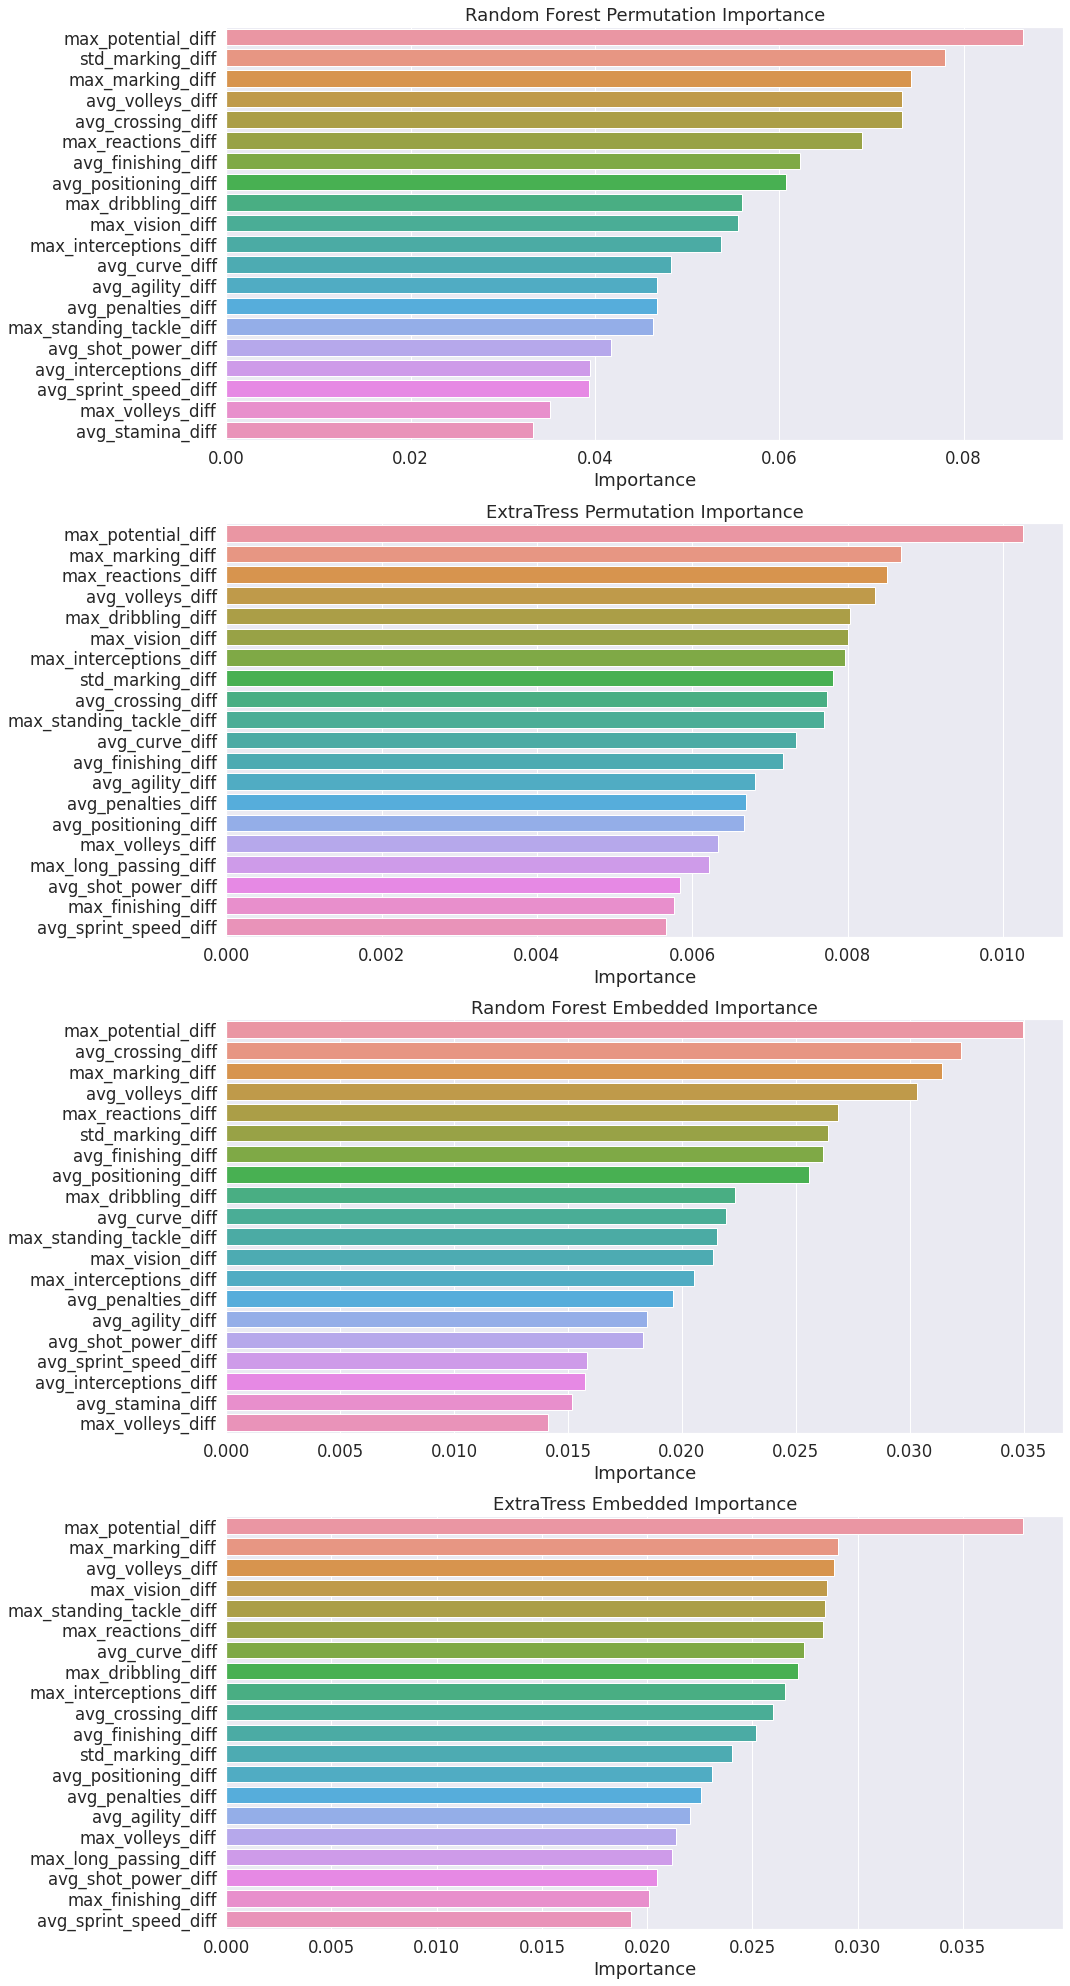

In [ ]:
figure, ((ax1,ax2,ax3,ax4)) = plt.subplots(nrows=4, ncols=1)
figure.set_size_inches(15,35)
sns.set(style="dark")
sns.set(font_scale=1.5)

sns.barplot(data=pi_features[:20], x="weight", y="feature", ax=ax1)
ax1.set(xlabel='Importance',title="Random Forest Permutation Importance", ylabel='')

sns.barplot(data=pi_features1[:20], x="weight", y="feature", ax=ax2)
ax2.set(xlabel='Importance',title="ExtraTress Permutation Importance", ylabel='')

sns.barplot(data=feat_imp[:20], x="weight", y="feature", ax=ax3)
ax3.set(xlabel='Importance',title="Random Forest Embedded Importance", ylabel='')

sns.barplot(data=feat_imp1[:20], x="weight", y="feature", ax=ax4)
ax4.set(xlabel='Importance',title="ExtraTress Embedded Importance", ylabel='')


In [ ]:
feat = pd.merge(feat_imp, feat_imp1, on='feature')
feat = pd.merge(feat, pi_features.drop('std',axis=1), on='feature')
feat = pd.merge(feat, pi_features1.drop('std',axis=1), on='feature')
feat.columns = ['feature','rf_imp','et_imp','rf_perm', 'et_perm']
feat['embedded_importance_avg'] = (feat['rf_imp'] + feat['et_imp']) / 2
feat['permumtation_importance_avg'] = (feat['rf_perm'] + feat['et_perm']) / 2
feat = feat.sort_values(ascending=True, by='permumtation_importance_avg')
feat.set_index('feature', inplace=True)
feat

,rf_imp,et_imp,rf_perm,et_perm,embedded_importance_avg,permumtation_importance_avg
feature,,,,,,
league_id_1,0.000223,0.002606,0.000220,0.000299,0.001414,0.000259
league_id_17642,0.000316,0.003428,0.000325,0.000475,0.001872,0.000400
league_id_19694,0.000539,0.004570,0.000633,0.000767,0.002555,0.000700
league_id_13274,0.000481,0.004728,0.000661,0.000911,0.002604,0.000786
league_id_10257,0.000531,0.005946,0.000546,0.001150,0.003239,0.000848
...,...,...,...,...,...,...
avg_crossing_diff,0.032267,0.025982,0.073338,0.007733,0.029125,0.040535
avg_volleys_diff,0.030302,0.028885,0.073365,0.008352,0.029594,0.040858
max_marking_diff,0.031416,0.029080,0.074320,0.008686,0.030248,0.041503


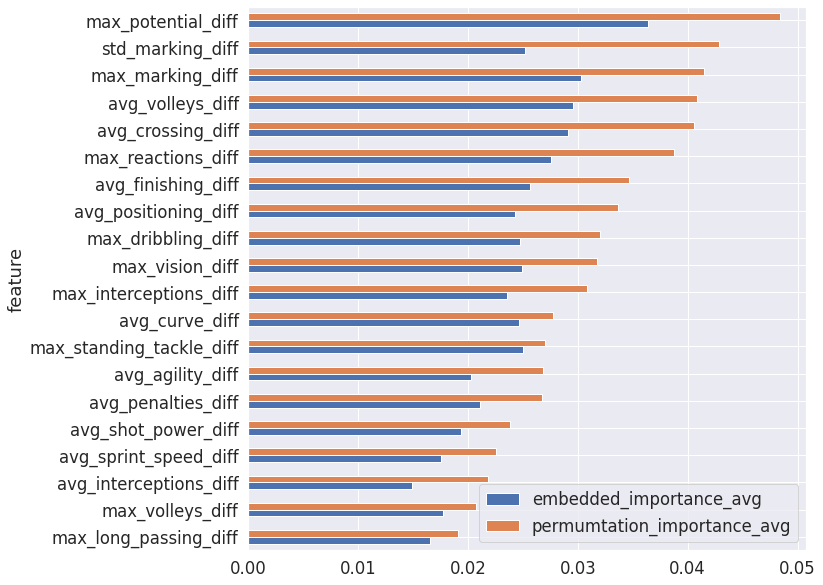

In [ ]:
feat[['embedded_importance_avg','permumtation_importance_avg']][-20:].plot.barh(figsize=(10,10))